<a href="https://colab.research.google.com/github/why-does-ie-still-exist/IrohCropper/blob/main/IrohCropper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installs dependencies and copies files from internet

In [ ]:
!pip install onnx onnxruntime-gpu numpy

     |████████████████████████████████| 14.5MB 239kB/s 
     |████████████████████████████████| 29.9MB 93kB/s 
     |████████████████████████████████| 394.3MB 41kB/s 
     |████████████████████████████████| 235kB 52.0MB/s 
     |████████████████████████████████| 9.5MB 47.7MB/s 
     |████████████████████████████████| 706kB 42.3MB/s 
  Created wheel for ludwig: filename=ludwig-0.3.3-cp37-none-any.whl size=326529 sha256=7ce9925027214e9dfdbf33441c054582e970b5563b9bc068246f318e628af54e
  Stored in directory: /root/.cache/pip/wheels/1e/a4/0e/682612ff0fc9c09e486e1b85c40d58b9c0cf574fdeb16121a1
Successfully built ludwig
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [ ]:
!mkdir pictures
!mkdir openprocessed
!mkdir closedprocessed
!mkdir collected

mkdir: cannot create directory ‘pictures’: File exists
mkdir: cannot create directory ‘openprocessed’: File exists
mkdir: cannot create directory ‘closedprocessed’: File exists
mkdir: cannot create directory ‘collected’: File exists


In [ ]:
!wget https://github.com/onnx/models/blob/master/vision/object_detection_segmentation/faster-rcnn/model/FasterRCNN-10.onnx?raw=true -O "FasterRCNN-10.onnx"
!wget https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat.jpg -O "pictures/internetcat.jpg"
!wget https://specials-images.forbesimg.com/imageserve/5db4c7b464b49a0007e9dfac/960x0.jpg?fit=scale -O "pictures/dog.jpg"

--2021-03-25 04:52:57--  https://github.com/onnx/models/blob/master/vision/object_detection_segmentation/faster-rcnn/model/FasterRCNN-10.onnx?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/onnx/models/raw/master/vision/object_detection_segmentation/faster-rcnn/model/FasterRCNN-10.onnx [following]
--2021-03-25 04:52:57--  https://github.com/onnx/models/raw/master/vision/object_detection_segmentation/faster-rcnn/model/FasterRCNN-10.onnx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/master/vision/object_detection_segmentation/faster-rcnn/model/FasterRCNN-10.onnx [following]
--2021-03-25 04:52:57--  https://media.githubusercontent.com/media/onnx/models/master/vision/object_detection_segmentation/faster-rcnn/model/Faste

###Mounts Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp /content/drive/MyDrive/irohbot/collected/PXL_20210112_033128489.jpg /content/pictures/hardcat.jpg
!cp -r /content/drive/MyDrive/irohpics/closed /content/
!cp -r /content/drive/MyDrive/irohpics/open /content/


Mounted at /content/drive


###Runs Faster RCNN

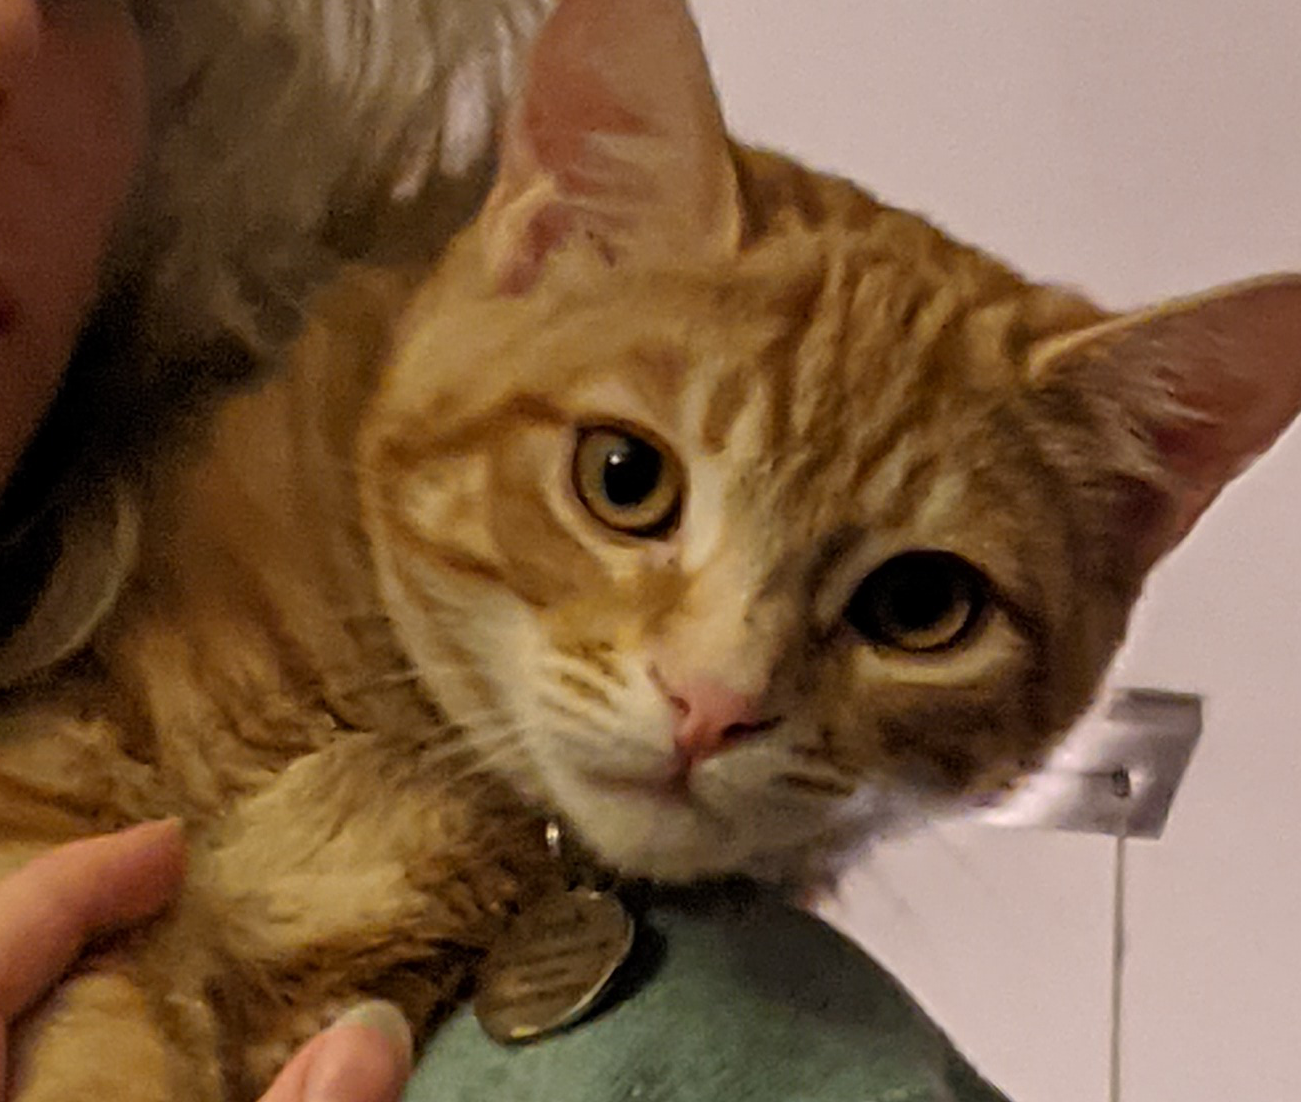

In [ ]:
import onnxruntime
import numpy as np
from PIL import Image, ImageOps
import os, warnings

model = "/content/FasterRCNN-10.onnx"
session = onnxruntime.InferenceSession(model, None)

# I didn't write this preprocessing code, this came with Faster RCNN
def preprocess(image):
    # Resize
    ratio = 800.0 / min(*image.size)
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    # From Wikipedia: "The term magic number or magic constant refers to the anti-pattern of using numbers directly in source code."
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image

    return image

def getscore(item):
  box, label, score = item
  if(label != 16):
    return 0
  else:
    return score

def extract(image, tosquare=False):
  filename = image.filename
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    image = ImageOps.exif_transpose(image)
  
  img_data = preprocess(image)
  input_name = "image"
  boxes, labels, scores = session.run(["6379","6381","6383"], {input_name: img_data})
  
  # Resize boxes
  ratio = 800.0 / min(*image.size)
  boxes /= ratio

  bounds, label, _ = max(zip(boxes, labels, scores), key=getscore)
  if(label == 16):
    image = image.crop(bounds)
    if tosquare:
      image = image.resize((max(image.size), max(image.size)), Image.BILINEAR)
    
    return image
  else:
    print("No cat found in {}".format(filename))

def extractdir(dirname, outputdir, suffix="", tosquare=False):
    for _, _,files in os.walk(dirname):
        for i, name in enumerate(files):
          try:
            img = Image.open("{}/{}".format(dirname, name))
            extract(img,tosquare).save("{}/{}{}.jpg".format(outputdir, i, suffix))
          except KeyboardInterrupt as k:
            raise k
          except Exception as e:
            print("Issue with {}".format(name))
          
extractdir("open","openprocessed", suffix="open", tosquare=True)
extractdir("closed","closedprocessed", suffix="closed",tosquare=True)

###Downloads Images so you can use them with Lobe

In [ ]:
!zip -r open.zip openprocessed
!zip -r closed.zip closedprocessed

from google.colab import files
files.download("/content/open.zip")
files.download("/content/closed.zip")

updating: openprocessed/ (stored 0%)
updating: openprocessed/4open.jpg (deflated 1%)
updating: openprocessed/21open.jpg (deflated 1%)
updating: openprocessed/1open.jpg (deflated 2%)
updating: openprocessed/15open.jpg (deflated 2%)
updating: openprocessed/42open.jpg (deflated 0%)
updating: openprocessed/0open.jpg (deflated 1%)
updating: openprocessed/52open.jpg (deflated 1%)
updating: openprocessed/18open.jpg (deflated 1%)
updating: openprocessed/32open.jpg (deflated 0%)
updating: openprocessed/48open.jpg (deflated 1%)
updating: openprocessed/50open.jpg (deflated 2%)
updating: openprocessed/40open.jpg (deflated 1%)
updating: openprocessed/47open.jpg (deflated 2%)
updating: openprocessed/37open.jpg (deflated 0%)
updating: openprocessed/45open.jpg (deflated 0%)
updating: openprocessed/14open.jpg (deflated 1%)
updating: openprocessed/53open.jpg (deflated 1%)
updating: openprocessed/22open.jpg (deflated 1%)
updating: openprocessed/17open.jpg (deflated 1%)
updating: openprocessed/35open.jpg 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Merges Files So Ludwig Can Use Them

In [ ]:
!cp -r openprocessed/. collected/
!cp -r closedprocessed/. collected/

In [ ]:
import os
import csv

classifications = [['class','image_path']]

for _, _,files in os.walk("./closedprocessed"):
    for name in files:
        # classifications.append(['closed', "collected/{name}".format(name=name)])
        classifications.append(['0', "collected/{name}".format(name=name)])

for _, _,files in os.walk("./openprocessed"):
    for name in files:
        # classifications.append(['open', "collected/{name}".format(name=name)])
        classifications.append(['1', "collected/{name}".format(name=name)])

filename = "actual.csv"

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(classifications)


###Runs Ludwig

In [ ]:
!pip install tensorflow-gpu ludwig[image]

In [ ]:
!cp -r "/content/drive/MyDrive/ibot2files/binary_config_test/resnet_128_bin.yaml" "/content/resnet_128.yaml"
!cp -r "/content/drive/MyDrive/ibot2files/binary_config_test/stacked_128_bin.yaml" "/content/stacked_128.yaml"
!cp -r "/content/drive/MyDrive/ibot2files/binary_config_test/stacked_256_bin.yaml" "/content/stacked_256.yaml"

In [ ]:
!cd /content/; ls; ludwig experiment \
  --dataset 'actual.csv' \
  --config 'resnet_128.yaml'

actual.csv	 drive		     pictures	       stacked_256.yaml
closed		 FasterRCNN-10.onnx  resnet_128.yaml
closedprocessed  open		     sample_data
collected	 openprocessed	     stacked_128.yaml
2021-03-23 22:23:45.282854: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking tensorflow_addons.layers.max_unpooling_2d.MaxUnpooling2D.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.3.3 - Experiment

2021-03-23 22:23:46.556292: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-23 22:23:46.558917: I tensorflow/stream_exe

In [ ]:
!cd /content/; ls; ludwig experiment \
  --dataset 'actual.csv' \
  --config 'stacked_128.yaml'

actual.csv	  closedprocessed     openprocessed    stacked_128.yaml
actual.hdf5	  collected	      pictures	       stacked_256.yaml
actual.meta.json  drive		      resnet_128.yaml
actual.split.csv  FasterRCNN-10.onnx  results
closed		  open		      sample_data
2021-03-23 22:27:12.274399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking tensorflow_addons.layers.max_unpooling_2d.MaxUnpooling2D.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.3.3 - Experiment

2021-03-23 22:27:13.579133: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla

In [ ]:
!cd /content/; ls; ludwig experiment \
  --dataset 'actual.csv' \
  --config 'stacked_256.yaml'

actual.csv	  closedprocessed     openprocessed    stacked_128.yaml
actual.hdf5	  collected	      pictures	       stacked_256.yaml
actual.meta.json  drive		      resnet_128.yaml
actual.split.csv  FasterRCNN-10.onnx  results
closed		  open		      sample_data
2021-03-23 22:30:18.786709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking tensorflow_addons.layers.max_unpooling_2d.MaxUnpooling2D.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.3.3 - Experiment

2021-03-23 22:30:20.104555: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla

###Basically useless face-extraction code, the accuracy is terrible

In [ ]:
!pip install opencv-python
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalcatface_extended.xml -O "hc_cat.xml"

In [ ]:
import cv2
from PIL import Image

import cv2

def rotate_image(mat, angle):
  #thanks Stackoverflow https://stackoverflow.com/questions/22041699/rotate-an-image-without-cropping-in-opencv-in-c/33564950#33564950
  # angle in degrees

  height, width = mat.shape[:2]
  image_center = (width/2, height/2)

  rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

  abs_cos = abs(rotation_mat[0,0])
  abs_sin = abs(rotation_mat[0,1])

  bound_w = int(height * abs_sin + width * abs_cos)
  bound_h = int(height * abs_cos + width * abs_sin)

  rotation_mat[0, 2] += bound_w/2 - image_center[0]
  rotation_mat[1, 2] += bound_h/2 - image_center[1]

  rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
  return rotated_mat

def cropface(open_cv_image):
  gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
  # load the cat detector Haar cascade, then detect cat faces
  # in the input image
  classifierloc = "hc_cat.xml"
  detector = cv2.CascadeClassifier(classifierloc)
  rects, _, confidences = detector.detectMultiScale3(gray, scaleFactor=1.001, #idk
      minNeighbors=2, minSize=(400, 400), outputRejectLevels = True)
  confidences = [val[0] for val in confidences]
  return zip(rects, confidences)

rotate = rotate_image(cv2.imread("extracted.jpg"),90)
boxinfo = cropface(rotate)
print([i for i in boxinfo])

for i, ((x, y, w, h), confidence) in enumerate(boxinfo):
  print (x, y, w, h)
  working = Image.open("extracted.jpg")
  working.crop((x, y, x + w, y + h)).save("{}.png".format(i))

[]
